In [1]:
import gym
from gym import wrappers
import time
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# If you have more than 1 GPU, you might want to specify which GPU for training.
os.environ['CUDA_VISIBLE_DEVICES']='0' # The second
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
GPU is available


# Constants

In [2]:
folder_name = '20220107_CartPole_SAC'
env_name = 'CartPole-v1'
monitor_name = f"./{folder_name}_monitor"

In [3]:
# Model related constant
n_action = 2
n_state = 4
wv_dim = 64
ff_dim = 1024

rho = 0.995
gamma = 0.99
lr = 1e-3
epsilon = 1e-6
dr = 0.1
alpha = 1e2

In [4]:
env = gym.make(env_name)
#env = wrappers.Monitor(env, monitor_name, force=True)
observation = env.reset()

## Test environment

In [5]:
# The action domain
print('-- Action ---')
print(env.action_space)
print('')
# The observing domain
print('--- Observation ---')
print(env.observation_space)
env.close()

-- Action ---
Discrete(2)

--- Observation ---
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [6]:
action = env.action_space.sample()
env.step(action)

(array([ 0.0126674 ,  0.19499825,  0.01272804, -0.29120266], dtype=float32),
 1.0,
 False,
 {})

In [7]:
st = time.time()
n_trial = 1
n_step = 1000
state_list = []
action_list = []
reward_list = []
# Initialize a New Env
for _ in range(n_trial):
    if env:
        env.close()
    env = gym.make(env_name)
    #env = wrappers.Monitor(env, monitor_name, force=True)
    state = env.reset()
    state_list.append(state)
    for _ in range(n_step):
        #prob = actor(np.array([state]))
        #log_prob = tf.math.log(prob)
        #action = tf.random.categorical(log_prob, 1)
        #action = action.numpy()[0,0]
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        action_list.append(action)
        reward_list.append(reward)
        if done:
            break
        else:
            state_list.append(state)
env.close()

# Make models

In [8]:
# Used to modeling the actions
# s -> policy
def getActor():
    s_input = Input((n_state,))
    m = Dense(ff_dim)(s_input)
    m = Activation('relu')(m)
    m = Dense(ff_dim//2)(m)
    m = Activation('relu')(m)
    m = Dense(wv_dim)(m)
    m = Activation('relu')(m)
    prob_output = Dense(n_action)(m)
    prob_output = Activation('softmax')(prob_output)
    model = Model(
        s_input,
        prob_output
    )
    return model

# Used to modeling immediate rewards
# s,a -> r
def getRewardFunction(idx):
    s_input = Input((n_state,))
    s_emb = Dense(wv_dim)(s_input)
    
    a_input = Input((1,), dtype = tf.int32)
    a_onehot = tf.one_hot(a_input, n_action)
    a_onehot = tf.reshape(a_onehot, (-1, n_action))
    a_emb = Dense(wv_dim)(a_onehot)
    
    m = BatchNormalization(epsilon=epsilon)(s_emb+a_emb)
    m = Dense(ff_dim)(m)
    m = Activation('relu')(m)
    m = Dropout(dr)(m)
    m = Dense(ff_dim//2)(m)
    m = Activation('relu')(m)
    m = Dense(wv_dim)(m)
    m = Activation('relu')(m)
    r_output = Dense(1)(m)
    model = Model(
        [s_input, a_input],
        r_output,
        name = f'r_func_{idx}',
    )
    return model

# Combine two reward function
# s,a -> r
def getEnsembleR():
    s_input = Input((n_state,))
    a_input = Input((1,))
    r_func1 = getRewardFunction(1)
    r_func2 = getRewardFunction(2)
    o1 = r_func1([s_input, a_input])
    o2 = r_func2([s_input, a_input])
    output = tf.math.minimum(o1, o2)
    model = Model(
        [s_input, a_input],
        output,
        name = 'reward_function',
    )
    return r_func1, r_func2, model

In [9]:
actor  = getActor()
r_func1, r_func2, r_func = getEnsembleR()
r_targ1, r_targ2, r_targ = getEnsembleR()
r_targ.set_weights(r_func.get_weights())

actor.summary()
r_func.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 1024)              5120      
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 activation_2 (Activation)   (None, 64)                0     

# Reinforcement Learning

### polyak averaging for target networks

In [10]:
def update_targ(func, targ, rho = rho):
    targ_params = targ.get_weights()
    func_params = func.get_weights()
    ans = [rho * targ_params[i] + (1-rho)*func_params[i] for i in range(len(func_params))]
    targ.set_weights(ans)
    return

# Reward function

In [11]:
r_func_optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
r_loss_object = tf.keras.losses.MeanSquaredError(reduction = 'none')
entropy_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'none')

# The loss for policy gradient with partition function
def r_func_loss(r_func_idx, s_in, s2_in, a_in, reward, done, gamma = gamma, alpha = alpha):
    prob_next = actor(s2_in)
    a_next = tf.math.argmax(prob_next, axis = 1)
    pred = r_func_idx([s_in, a_in])
    pred_next = r_targ([s2_in, a_next])
    entropy = entropy_object(a_next, prob_next)
    backup =  reward + gamma * (1-done) * (pred_next + alpha * entropy)
    loss = r_loss_object(backup, pred)
    return tf.reduce_mean(loss)

@tf.function()
def train_r_step(s_in, s2_in, a_in, reward, done):
    pred = None
    loss = None
    with tf.GradientTape() as tape:
        loss = r_func_loss(r_func1, s_in, s2_in, a_in, reward, done) \
            + r_func_loss(r_func2, s_in, s2_in, a_in, reward, done)
    gradients = tape.gradient(loss, r_func.trainable_variables)
    gradients = [(tf.clip_by_norm(grad, 1.0)) for grad in gradients]
    r_func_optimizer.apply_gradients(zip(gradients, r_func.trainable_variables))    
    return loss

r_func.compile(
    loss = 'mean_squared_error',
    optimizer=Adam(learning_rate = lr),
    metrics=['mean_squared_error'],
)

# Actor(Predition function) 

In [12]:
actor_optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
entropy_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction = 'none')

def actor_loss(s_in, alpha = alpha):
    prob = actor(s_in)
    #a = tf.math.argmax(prob, axis = 1)
    log_prob = tf.math.log(prob)
    a = tf.random.categorical(log_prob, 1)
    r = r_func([s_in, a])
    r = r- tf.reduce_mean(r)
    entropy = entropy_object(a, prob)
    entropy = tf.reshape(entropy, r.shape)
    # The reward should be as higher as possible
    return tf.reduce_mean((r - alpha) * entropy)

@tf.function()
def train_a_step(s_in, a_in):
    pred = None
    loss = None
    with tf.GradientTape() as tape:
        loss = actor_loss(s_in)
    gradients = tape.gradient(loss, actor.trainable_variables)
    gradients = [(tf.clip_by_norm(grad, 1.0)) for grad in gradients]
    actor_optimizer.apply_gradients(zip(gradients, actor.trainable_variables))    
    return loss

actor.compile(
    loss = 'categorical_crossentropy',
    optimizer=Adam(learning_rate = lr),
    metrics=['categorical_crossentropy'],
)

## Replay buffer

In [13]:
class replay_buffer():
    def __init__(self, n_replay_buffer):
        self.n_replay_buffer = n_replay_buffer
        self.holder = []
        return
    # Put new trajectories into the replay buffer
    def store(self, _input):
        self.holder.append(_input)
        self.holder = self.holder[-self.n_replay_buffer:]
        return
    # Take some of trajectories from the replay buffer
    def sample(self, q_len, idx = None):
        if q_len > len(self.holder):
            return self.holder
        elif isinstance(idx, type(None)):
            idx = len(self.holder)
            np.random.shuffle(idx)
            return [self.holder[i] for i in idx[:q_len]]
        else:
            return [self.holder[i] for i in idx[:q_len]]

### Test replay buffer

In [14]:
example_rb = replay_buffer(16)
for i in range(10):
    example_rb.store(np.ones((3)))
print(example_rb.holder)

[array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.]), array([1., 1., 1.])]


# Entire training progress
I follow [this instruction](https://spinningup.openai.com/en/latest/_modules/spinup/algos/pytorch/sac/sac.html) from OpenAI Soft Actor Critic.

In [15]:
# Training related Constants 
steps_per_epoch = 4000 # Number of pairs in each epoch.
epochs = 10000
replay_buffer_size = 100000 # 100k pairs
batch_size = 1000 # minibatch size for SGD
start_steps = 10000 # number of pairs using random uniform actions
update_after = 10000 # number of pairs before training
update_every = 50 # Update the model every 50 pairs 
num_test_episodes = 10 # Not used
max_ep_len=1000
total_steps = steps_per_epoch * epochs # epoch size
save_freq = 1

In [16]:
a_loss_list = []
r_loss_list = []
score_list = []
ep_ret_list = []
ep_len_list = []

# Replay buffer
s_replay_buffer = replay_buffer(replay_buffer_size)
s2_replay_buffer = replay_buffer(replay_buffer_size)
a_replay_buffer = replay_buffer(replay_buffer_size)
r_replay_buffer = replay_buffer(replay_buffer_size)
d_replay_buffer = replay_buffer(replay_buffer_size)

In [17]:
env.close()
st = time.time()
state, ep_ret, ep_len = env.reset(), 0, 0

train_r_loss = tf.keras.metrics.Mean()
train_a_loss = tf.keras.metrics.Mean()

for t in range(total_steps):
    # Until start_steps have elapsed, randomly sample actions
    # from a uniform distribution for better exploration. Afterwards, 
    # use the learned policy. 
    if t > start_steps:
        prob = actor(np.array([state]))
        log_prob = tf.math.log(prob)
        action = tf.random.categorical(log_prob, 1)
        action = action.numpy()[0,0]
        #action = np.argmax(prob, axis = 1)[0]
    else:
        action = env.action_space.sample()
    # Step the env
    state2, reward, done, _ = env.step(action)
    ep_ret += reward
    ep_len += 1
        
    # Ignore the "done" signal if it comes from hitting the time
    # horizon (that is, when it's an artificial terminal signal
    # that isn't based on the agent's state)
    done = False if ep_len==max_ep_len else done
    
    # Store experience to replay buffer
    s_replay_buffer.store( state)
    s2_replay_buffer.store(state2)
    a_replay_buffer.store( [action])
    r_replay_buffer.store( [reward])
    d_replay_buffer.store( [done])
    
    # Super critical, easy to overlook step: make sure to update 
    # most recent observation!
    state = state2
    
    # End of trajectory handling
    if done or (ep_len == max_ep_len):
        elapsed_time = time.time() - st
        st = time.time()
        ep_len_list.append(ep_len)
        ep_ret_list.append(ep_ret)
        try:
            r_loss_list.append(r_loss)
            a_loss_list.append(a_loss)
        except:
            pass
        
        print(
            f'Elapsed steps: {t+1:8d}, '
            f'ep_len: {ep_len:4d}, '
            f'ep_ret: {ep_ret:7.2f}, '
            #f'R loss: {train_r_loss.result():8.4f}, '
            #f'A loss: {train_a_loss.result():8.4f}, '
            f'Elapsed time: {elapsed_time:4.0f} secs'
        )
        # Reset
        state, ep_ret, ep_len = env.reset(), 0, 0
        train_a_loss.reset_state()
        train_r_loss.reset_state()
        
    # Update handling
    if t >= update_after and t % update_every == 0:
        for j in range(update_every):
            len_current_buffer = len(s_replay_buffer.holder)
            buffer_idx = np.random.randint(0, len_current_buffer, size=batch_size)
            
            state_array  = np.array(
                s_replay_buffer.sample(batch_size, buffer_idx), 
                dtype = np.float32
            )
            s2_array     = np.array(
                s2_replay_buffer.sample(batch_size, buffer_idx), 
                dtype = np.float32
            )
            action_array = np.array(
                a_replay_buffer.sample(batch_size, buffer_idx), 
                dtype = np.int32
            )
            reward_array = np.array(
                r_replay_buffer.sample(batch_size, buffer_idx),
                dtype = np.float32
            )
            done_array = np.array(
                d_replay_buffer.sample(batch_size, buffer_idx),
                dtype = np.float32
            )
            
            actor.trainable = False
            r_func.trainable = True
            
            r_loss = train_r_step(
                state_array, 
                s2_array, 
                action_array,
                reward_array,
                done_array,
            )
            train_r_loss.update_state(r_loss)
            
        
            actor.trainable = True
            r_func.trainable = False
                        
            a_loss = train_a_step(
                state_array,
                action_array,
            )
            train_a_loss.update_state(a_loss)
            
            update_targ(r_func, r_targ)
            
        print(
            f'Elapsed steps: {t+1:8d}, '
            #f'ep_len: {ep_len:4d}, '
            #f'ep_ret: {ep_ret:7.2f}, '
            f'R loss: {train_r_loss.result():8.4f}, '
            f'A loss: {train_a_loss.result():8.4f}, '
            #f'Elapsed time: {elapsed_time:4.0f} secs'
        )
            
    # End of epoch handling
    if (t+1) % steps_per_epoch == 0:
        epoch = (t+1) // steps_per_epoch
        
        # Save model
        if (epoch % save_freq) == 0 or (epoch == epochs):
            r_func.save(f'{folder_name}/r_func_current.h5')
            actor.save(f'{folder_name}/actor_current.h5')
            
            r_func.save(f'{folder_name}/r_func_{epoch:04d}.h5')
            actor.save(f'{folder_name}/actor_{epoch:04d}.h5')
            
            print(f'Epoch {epoch}, Model saved')

            

Elapsed steps:       16, ep_len:   16, ep_ret:   16.00, Elapsed time:    0 secs
Elapsed steps:       55, ep_len:   39, ep_ret:   39.00, Elapsed time:    0 secs
Elapsed steps:       84, ep_len:   29, ep_ret:   29.00, Elapsed time:    0 secs
Elapsed steps:       99, ep_len:   15, ep_ret:   15.00, Elapsed time:    0 secs
Elapsed steps:      129, ep_len:   30, ep_ret:   30.00, Elapsed time:    0 secs
Elapsed steps:      185, ep_len:   56, ep_ret:   56.00, Elapsed time:    0 secs
Elapsed steps:      209, ep_len:   24, ep_ret:   24.00, Elapsed time:    0 secs
Elapsed steps:      217, ep_len:    8, ep_ret:    8.00, Elapsed time:    0 secs
Elapsed steps:      239, ep_len:   22, ep_ret:   22.00, Elapsed time:    0 secs
Elapsed steps:      251, ep_len:   12, ep_ret:   12.00, Elapsed time:    0 secs
Elapsed steps:      274, ep_len:   23, ep_ret:   23.00, Elapsed time:    0 secs
Elapsed steps:      302, ep_len:   28, ep_ret:   28.00, Elapsed time:    0 secs
Elapsed steps:      354, ep_len:   52, e

Elapsed steps:     2804, ep_len:   15, ep_ret:   15.00, Elapsed time:    0 secs
Elapsed steps:     2821, ep_len:   17, ep_ret:   17.00, Elapsed time:    0 secs
Elapsed steps:     2862, ep_len:   41, ep_ret:   41.00, Elapsed time:    0 secs
Elapsed steps:     2891, ep_len:   29, ep_ret:   29.00, Elapsed time:    0 secs
Elapsed steps:     2915, ep_len:   24, ep_ret:   24.00, Elapsed time:    0 secs
Elapsed steps:     2933, ep_len:   18, ep_ret:   18.00, Elapsed time:    0 secs
Elapsed steps:     2950, ep_len:   17, ep_ret:   17.00, Elapsed time:    0 secs
Elapsed steps:     2966, ep_len:   16, ep_ret:   16.00, Elapsed time:    0 secs
Elapsed steps:     2990, ep_len:   24, ep_ret:   24.00, Elapsed time:    0 secs
Elapsed steps:     3020, ep_len:   30, ep_ret:   30.00, Elapsed time:    0 secs
Elapsed steps:     3050, ep_len:   30, ep_ret:   30.00, Elapsed time:    0 secs
Elapsed steps:     3087, ep_len:   37, ep_ret:   37.00, Elapsed time:    0 secs
Elapsed steps:     3098, ep_len:   11, e

Elapsed steps:     5275, ep_len:   30, ep_ret:   30.00, Elapsed time:    0 secs
Elapsed steps:     5298, ep_len:   23, ep_ret:   23.00, Elapsed time:    0 secs
Elapsed steps:     5328, ep_len:   30, ep_ret:   30.00, Elapsed time:    0 secs
Elapsed steps:     5367, ep_len:   39, ep_ret:   39.00, Elapsed time:    0 secs
Elapsed steps:     5393, ep_len:   26, ep_ret:   26.00, Elapsed time:    0 secs
Elapsed steps:     5409, ep_len:   16, ep_ret:   16.00, Elapsed time:    0 secs
Elapsed steps:     5440, ep_len:   31, ep_ret:   31.00, Elapsed time:    0 secs
Elapsed steps:     5451, ep_len:   11, ep_ret:   11.00, Elapsed time:    0 secs
Elapsed steps:     5475, ep_len:   24, ep_ret:   24.00, Elapsed time:    0 secs
Elapsed steps:     5532, ep_len:   57, ep_ret:   57.00, Elapsed time:    0 secs
Elapsed steps:     5559, ep_len:   27, ep_ret:   27.00, Elapsed time:    0 secs
Elapsed steps:     5577, ep_len:   18, ep_ret:   18.00, Elapsed time:    0 secs
Elapsed steps:     5627, ep_len:   50, e

Elapsed steps:     7829, ep_len:   22, ep_ret:   22.00, Elapsed time:    0 secs
Elapsed steps:     7881, ep_len:   52, ep_ret:   52.00, Elapsed time:    0 secs
Elapsed steps:     7899, ep_len:   18, ep_ret:   18.00, Elapsed time:    0 secs
Elapsed steps:     7911, ep_len:   12, ep_ret:   12.00, Elapsed time:    0 secs
Elapsed steps:     7925, ep_len:   14, ep_ret:   14.00, Elapsed time:    0 secs
Elapsed steps:     7945, ep_len:   20, ep_ret:   20.00, Elapsed time:    0 secs
Elapsed steps:     7961, ep_len:   16, ep_ret:   16.00, Elapsed time:    0 secs
Elapsed steps:     7974, ep_len:   13, ep_ret:   13.00, Elapsed time:    0 secs
Elapsed steps:     7989, ep_len:   15, ep_ret:   15.00, Elapsed time:    0 secs
Elapsed steps:     8000, ep_len:   11, ep_ret:   11.00, Elapsed time:    0 secs
Epoch 2, Model saved
Elapsed steps:     8017, ep_len:   17, ep_ret:   17.00, Elapsed time:    0 secs
Elapsed steps:     8037, ep_len:   20, ep_ret:   20.00, Elapsed time:    0 secs
Elapsed steps:     

Elapsed steps:    10151, R loss: 341.0975, A loss: -68.3414, 
Elapsed steps:    10196, ep_len:   71, ep_ret:   71.00, Elapsed time:    5 secs
Elapsed steps:    10201, R loss: 343.5994, A loss: -69.2270, 
Elapsed steps:    10222, ep_len:   26, ep_ret:   26.00, Elapsed time:    5 secs
Elapsed steps:    10251, R loss: 437.0025, A loss: -68.4991, 
Elapsed steps:    10287, ep_len:   65, ep_ret:   65.00, Elapsed time:    5 secs
Elapsed steps:    10301, R loss: 710.0477, A loss: -49.5535, 
Elapsed steps:    10304, ep_len:   17, ep_ret:   17.00, Elapsed time:    5 secs
Elapsed steps:    10351, R loss: 549.7122, A loss: -22.8350, 
Elapsed steps:    10391, ep_len:   87, ep_ret:   87.00, Elapsed time:    5 secs
Elapsed steps:    10401, R loss: 605.2561, A loss: -26.8877, 
Elapsed steps:    10422, ep_len:   31, ep_ret:   31.00, Elapsed time:    5 secs
Elapsed steps:    10451, ep_len:   29, ep_ret:   29.00, Elapsed time:    0 secs
Elapsed steps:    10451, R loss: 741.3783, A loss: -29.6147, 
Elapse

Elapsed steps:    14201, R loss: 127.4102, A loss:  -3.0375, 
Elapsed steps:    14251, R loss: 119.9698, A loss:  -2.7939, 
Elapsed steps:    14255, ep_len:  113, ep_ret:  113.00, Elapsed time:   14 secs
Elapsed steps:    14301, R loss: 118.3183, A loss:  -2.9017, 
Elapsed steps:    14351, R loss: 126.1055, A loss:  -3.0257, 
Elapsed steps:    14388, ep_len:  133, ep_ret:  133.00, Elapsed time:   10 secs
Elapsed steps:    14401, R loss: 124.4162, A loss:  -2.8676, 
Elapsed steps:    14451, R loss: 117.4250, A loss:  -2.7093, 
Elapsed steps:    14501, R loss: 111.2367, A loss:  -2.6414, 
Elapsed steps:    14551, R loss: 110.5267, A loss:  -2.5977, 
Elapsed steps:    14565, ep_len:  177, ep_ret:  177.00, Elapsed time:   19 secs
Elapsed steps:    14601, R loss: 108.9505, A loss:  -2.5831, 
Elapsed steps:    14651, R loss: 109.1748, A loss:  -2.5472, 
Elapsed steps:    14701, R loss: 110.9224, A loss:  -2.5781, 
Elapsed steps:    14751, R loss: 111.8637, A loss:  -2.6667, 
Elapsed steps:  

Elapsed steps:    19051, R loss: 360.9713, A loss: -10.4109, 
Elapsed steps:    19101, R loss: 379.4500, A loss: -11.1651, 
Elapsed steps:    19151, R loss: 400.6616, A loss: -12.3952, 
Elapsed steps:    19201, R loss: 415.3103, A loss: -13.1623, 
Elapsed steps:    19251, R loss: 436.7484, A loss: -13.7304, 
Elapsed steps:    19264, ep_len:  227, ep_ret:  227.00, Elapsed time:   23 secs
Elapsed steps:    19301, R loss: 712.6186, A loss: -19.7614, 
Elapsed steps:    19351, R loss: 773.6580, A loss: -21.5408, 
Elapsed steps:    19401, R loss: 766.8324, A loss: -21.0624, 
Elapsed steps:    19451, R loss: 749.5417, A loss: -20.7130, 
Elapsed steps:    19501, R loss: 740.2296, A loss: -20.2016, 
Elapsed steps:    19551, R loss: 737.5183, A loss: -20.0146, 
Elapsed steps:    19563, ep_len:  299, ep_ret:  299.00, Elapsed time:   40 secs
Elapsed steps:    19601, R loss: 852.8800, A loss: -18.9140, 
Elapsed steps:    19651, R loss: 839.9539, A loss: -19.1123, 
Elapsed steps:    19701, R loss: 7

Elapsed steps:    24551, R loss: 742.7582, A loss: -22.8859, 
Elapsed steps:    24601, R loss: 721.2018, A loss: -21.8015, 
Elapsed steps:    24651, R loss: 712.9210, A loss: -20.9811, 
Elapsed steps:    24701, R loss: 701.8120, A loss: -20.6167, 
Elapsed steps:    24751, R loss: 693.5863, A loss: -20.1329, 
Elapsed steps:    24801, R loss: 698.2922, A loss: -20.0682, 
Elapsed steps:    24851, R loss: 706.7236, A loss: -20.2585, 
Elapsed steps:    24877, ep_len:  500, ep_ret:  500.00, Elapsed time:   68 secs
Elapsed steps:    24901, R loss: 834.3715, A loss: -23.8999, 
Elapsed steps:    24951, R loss: 766.3680, A loss: -23.3807, 
Elapsed steps:    25001, R loss: 734.2100, A loss: -22.6480, 
Elapsed steps:    25051, R loss: 720.6548, A loss: -23.1991, 
Elapsed steps:    25101, R loss: 706.8923, A loss: -23.8058, 
Elapsed steps:    25151, R loss: 699.8969, A loss: -24.1791, 
Elapsed steps:    25182, ep_len:  305, ep_ret:  305.00, Elapsed time:   39 secs
Elapsed steps:    25201, R loss: 8

Elapsed steps:    29851, R loss: 662.9046, A loss: -18.2843, 
Elapsed steps:    29873, ep_len:  335, ep_ret:  335.00, Elapsed time:   44 secs
Elapsed steps:    29901, R loss: 749.1735, A loss: -23.6199, 
Elapsed steps:    29951, R loss: 926.5433, A loss: -25.6154, 
Elapsed steps:    30001, R loss: 907.8946, A loss: -24.5034, 
Elapsed steps:    30051, R loss: 887.4470, A loss: -24.5161, 
Elapsed steps:    30101, R loss: 904.3489, A loss: -25.1378, 
Elapsed steps:    30151, R loss: 903.3191, A loss: -25.3851, 
Elapsed steps:    30201, R loss: 950.2986, A loss: -26.8519, 
Elapsed steps:    30246, ep_len:  373, ep_ret:  373.00, Elapsed time:   49 secs
Elapsed steps:    30251, R loss: 1376.9437, A loss: -35.3861, 
Elapsed steps:    30301, R loss: 1334.2933, A loss: -34.8004, 
Elapsed steps:    30351, R loss: 1349.4431, A loss: -33.9810, 
Elapsed steps:    30401, R loss: 1368.1366, A loss: -34.8997, 
Elapsed steps:    30451, R loss: 1361.2172, A loss: -35.0647, 
Elapsed steps:    30501, R lo

Elapsed steps:    35301, R loss: 2920.1465, A loss: -27.1398, 
Elapsed steps:    35311, ep_len:  315, ep_ret:  315.00, Elapsed time:   43 secs
Elapsed steps:    35320, ep_len:    9, ep_ret:    9.00, Elapsed time:    0 secs
Elapsed steps:    35331, ep_len:   11, ep_ret:   11.00, Elapsed time:    0 secs
Elapsed steps:    35346, ep_len:   15, ep_ret:   15.00, Elapsed time:    0 secs
Elapsed steps:    35351, R loss: 7067.5981, A loss: -26.6823, 
Elapsed steps:    35401, R loss: 4441.9951, A loss: -26.0903, 
Elapsed steps:    35451, R loss: 3543.8767, A loss: -25.7065, 
Elapsed steps:    35501, R loss: 3083.2141, A loss: -24.8768, 
Elapsed steps:    35537, ep_len:  191, ep_ret:  191.00, Elapsed time:   24 secs
Elapsed steps:    35551, R loss: 1392.4247, A loss: -19.2838, 
Elapsed steps:    35601, R loss: 1385.0227, A loss: -18.9584, 
Elapsed steps:    35651, R loss: 1326.4004, A loss: -18.0074, 
Elapsed steps:    35701, R loss: 1347.5306, A loss: -17.9468, 
Elapsed steps:    35703, ep_len: 

Elapsed steps:    39351, R loss: 6098.0913, A loss: -17.2704, 
Elapsed steps:    39401, R loss: 3754.5176, A loss: -15.5450, 
Elapsed steps:    39451, R loss: 3540.3914, A loss: -16.1598, 
Elapsed steps:    39501, R loss: 2942.8447, A loss: -14.2207, 
Elapsed steps:    39551, R loss: 2655.2634, A loss: -14.2676, 
Elapsed steps:    39601, R loss: 2427.4299, A loss: -13.5606, 
Elapsed steps:    39651, R loss: 2437.7290, A loss: -12.8422, 
Elapsed steps:    39670, ep_len:  321, ep_ret:  321.00, Elapsed time:   41 secs
Elapsed steps:    39686, ep_len:   16, ep_ret:   16.00, Elapsed time:    0 secs
Elapsed steps:    39698, ep_len:   12, ep_ret:   12.00, Elapsed time:    0 secs
Elapsed steps:    39701, R loss: 3897.4355, A loss:  -8.5398, 
Elapsed steps:    39751, R loss: 5886.6504, A loss: -10.1005, 
Elapsed steps:    39801, R loss: 6018.8452, A loss: -13.0967, 
Elapsed steps:    39851, R loss: 4945.3672, A loss: -13.2267, 
Elapsed steps:    39901, R loss: 4201.4575, A loss: -14.0060, 
Elap

Elapsed steps:    44283, ep_len:   12, ep_ret:   12.00, Elapsed time:    0 secs
Elapsed steps:    44301, R loss: 9192.6875, A loss: -34.7234, 
Elapsed steps:    44307, ep_len:   24, ep_ret:   24.00, Elapsed time:    7 secs
Elapsed steps:    44351, R loss: 8219.8691, A loss: -31.4805, 
Elapsed steps:    44401, R loss: 6656.9102, A loss: -32.6572, 
Elapsed steps:    44451, R loss: 5486.0449, A loss: -34.5962, 
Elapsed steps:    44501, R loss: 4918.4570, A loss: -34.9261, 
Elapsed steps:    44551, R loss: 5140.8838, A loss: -33.9544, 
Elapsed steps:    44601, R loss: 4652.1162, A loss: -33.5100, 
Elapsed steps:    44651, R loss: 4313.2817, A loss: -33.0248, 
Elapsed steps:    44683, ep_len:  376, ep_ret:  376.00, Elapsed time:   52 secs
Elapsed steps:    44701, R loss: 2749.6709, A loss: -36.6277, 
Elapsed steps:    44751, R loss: 4205.5005, A loss: -39.2909, 
Elapsed steps:    44801, R loss: 3786.9539, A loss: -37.8644, 
Elapsed steps:    44835, ep_len:  152, ep_ret:  152.00, Elapsed tim

Elapsed steps:    49101, R loss: 1976.9702, A loss: -39.1393, 
Elapsed steps:    49151, R loss: 1961.2258, A loss: -36.9341, 
Elapsed steps:    49164, ep_len:  249, ep_ret:  249.00, Elapsed time:   30 secs
Elapsed steps:    49201, R loss: 1870.6830, A loss: -24.0939, 
Elapsed steps:    49251, R loss: 1899.0513, A loss: -24.7393, 
Elapsed steps:    49301, R loss: 1906.6450, A loss: -26.3419, 
Elapsed steps:    49351, R loss: 1869.3564, A loss: -27.8736, 
Elapsed steps:    49401, R loss: 1854.3202, A loss: -27.9171, 
Elapsed steps:    49451, R loss: 1875.3116, A loss: -27.9656, 
Elapsed steps:    49501, R loss: 1837.5922, A loss: -28.2562, 
Elapsed steps:    49551, R loss: 1792.9175, A loss: -28.9358, 
Elapsed steps:    49601, R loss: 1792.0787, A loss: -29.9338, 
Elapsed steps:    49651, R loss: 1767.0150, A loss: -30.6067, 
Elapsed steps:    49664, ep_len:  500, ep_ret:  500.00, Elapsed time:   60 secs
Elapsed steps:    49701, R loss: 1653.2577, A loss: -34.7652, 
Elapsed steps:    497

Elapsed steps:    54601, R loss: 2658.8025, A loss: -59.8542, 
Elapsed steps:    54651, R loss: 2503.7263, A loss: -57.9732, 
Elapsed steps:    54701, R loss: 2425.9854, A loss: -58.3577, 
Elapsed steps:    54751, R loss: 2443.1111, A loss: -58.5288, 
Elapsed steps:    54776, ep_len:  239, ep_ret:  239.00, Elapsed time:   35 secs
Elapsed steps:    54801, R loss: 2230.3196, A loss: -56.3001, 
Elapsed steps:    54851, R loss: 2158.1196, A loss: -53.9361, 
Elapsed steps:    54901, R loss: 2085.9807, A loss: -50.7045, 
Elapsed steps:    54951, R loss: 2139.1248, A loss: -48.0462, 
Elapsed steps:    55001, R loss: 2184.9050, A loss: -47.8328, 
Elapsed steps:    55051, R loss: 2237.5759, A loss: -48.3182, 
Elapsed steps:    55101, R loss: 2266.1853, A loss: -47.5376, 
Elapsed steps:    55151, R loss: 2250.9463, A loss: -46.8753, 
Elapsed steps:    55201, R loss: 2253.1284, A loss: -47.3491, 
Elapsed steps:    55251, R loss: 2257.1201, A loss: -48.1170, 
Elapsed steps:    55276, ep_len:  500,

KeyboardInterrupt: 

# Plot the loss curve

## ep_len_list
The length of a gameplay

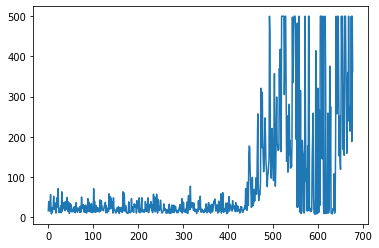

In [18]:
plt.plot(ep_len_list)
plt.show()

## ep_ret_list
The total reward of a gameplay.

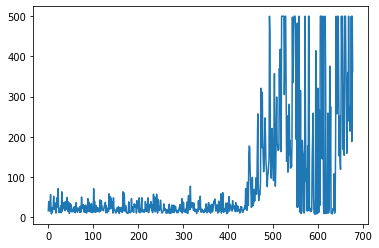

In [19]:
plt.plot(ep_ret_list)
plt.show()

## R Loss
The loss of r_func

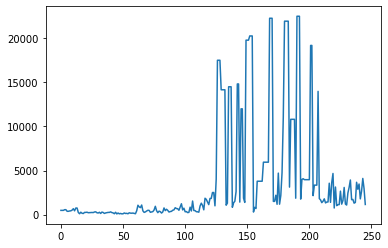

In [20]:
plt.plot(r_loss_list)
plt.show()

## A Loss
The reward of actor

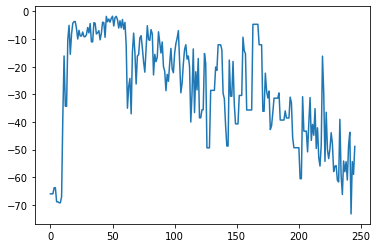

In [21]:
plt.plot(a_loss_list)
plt.show()

# Let's see how the model works

In [ ]:
env.close()
st = time.time()
n_trial = 1
n_step = 1000

for i in range(n_trial):
    # Initialize a New Env
    if env:
        env.close()
    env = gym.make(env_name)
    env = wrappers.Monitor(env, monitor_name, force=True)
    state = env.reset()
    actor = load_model(f'{folder_name}/actor_current.h5')
    
    pbar = tqdm(range(n_step))
    for char in pbar:
        pbar.set_description("Potential %s" % r)
        prob = actor(np.array([state]))
        log_prob = tf.math.log(prob)
        a = tf.random.categorical(log_prob, 1)
        action = a.numpy()[0,0]
        #action = np.argmax(prob[0])
        state, reward, done, info = env.step(action)
        if done:
            break

    
env.close()